<div style="background-image: url('https://images.unsplash.com/photo-1581939768677-ea85e0c05bbf?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60'); background-size: 40%; background-repeat: no-repeat; background-position: right;">

# Shifted Sphere Function

$F_1(x) = \sum_{i=1}^D z_i^2 + f_{bias_1}$, $ z = x - o $, $x = [x_1,x_2,...,x_D]$

D: dimensions. $o = [o_1, o_2, ..., o_D]$ : the shifted global optimum.

### Properties:
- Unimodal
- Shifted
- Separable
- Scalable
- Dimension D as 100, 500 and 1000
- $x∈[−100,100]^D$ , Global optimum: x* = o , $F_1(x^*) = f_{bias_1} = - 450$
   </div>

In [7]:
import sys
sys.path.append('../') # just to allow using python files at another directory

import numpy as np
from shifted_go import * # shifted global optimum of the functions
from algorithms import * # optimization algorithms customized
from utils import * # functions used to summarise the results

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import pygmo as pg # package with the optimization algorithms
import time
import pandas as pd

## I. Defining the class for the optimization algorithm
<hr>

In [8]:
class shifted_sphere:
    
    def __init__(self, dim):
        self.dim = dim
        self.name = 'shifted sphere'

    def fitness(self, x):
        
        z = np.array(x)
        if z.ndim > 1:
            z[:] = z - (np.array(sphere[:z.shape[1]]))
            res = np.sum(z**2, axis = 1) + f_bias[0]
        else:
            if np.isscalar(x) == True:
                z = z - np.array(sphere[0])
            else:
                z[:] = z - (np.array(sphere[:len(x)]))
            res = np.sum(z**2) + f_bias[0]
        return [res]
    
    def get_bounds(self):
        return ([-100]*self.dim,[100]*self.dim)
    
    def get_nic(self): # number of inequality constraints
        return 0
    
    def get_nec(self): # number of equality constraints
        return 0
    
    def get_name(self): # number of equality constraints
        return self.name + ' - dimension ' + str(self.dim)
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

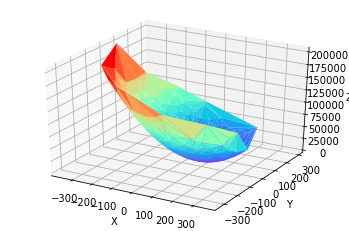

In [9]:
grid = 100*np.random.randn(2000, 2)
function = shifted_sphere(2)
z = function.fitness(grid)
ax = plt.axes(projection='3d')

ax.plot_trisurf(grid[:,0], grid[:,1], np.array(z).flatten(), cmap='rainbow', linewidth=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# II. Optimizing the function using metaheuristics

<hr>

## II.1 Dimension = 50 

As the function sphere is unimodal and separable most of the algorithms are supposed to show a good performance, so let's  explore the convergence of some of them, considering the parameters necessary to error less than .1%

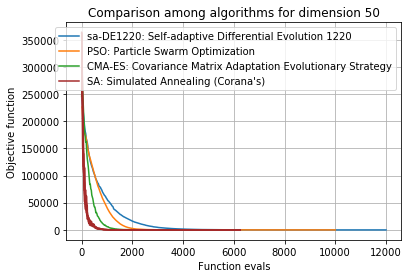

In [23]:
prob = pg.problem(shifted_sphere(50))
stats = []

udas = [pg.de1220(gen=600, allowed_variants=[18], variant_adptv=1, ftol=1e-09, xtol=1e-09), 
        pg.pso(gen=500, omega= .7, eta1=0.5, eta2=4, max_vel = .05, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
        pg.cmaes(gen=200, cc=-1, cs=-1, c1=-1, cmu=-1, sigma0=.5, ftol=1e-9, 
            xtol=1e-9, memory=False, force_bounds=True)]
for uda in udas: 
    logs = []
    best = []
    evals = []
    start_time = time.time()
    for i in range(25):
        algo = pg.algorithm(uda)
        algo.set_verbosity(1) # regulates both screen and log verbosity
        pop = pg.population(prob, 20)
        sol = algo.evolve(pop)
        logs.append(algo.extract(type(uda)).get_log())
        best.append(sol.champion_f)
        evals.append(sol.problem.get_fevals())
    
    end_time = time.time()
    logs = np.array(logs)
    stats.append([algo.get_name(), (end_time-start_time)/25, np.mean(np.array(evals)), np.max(np.array(best)), 
                    np.min(np.array(best)), np.mean(np.array(best)), np.median(np.array(best))])
    avg_log = np.average(logs,0)
    plt.plot(avg_log[:,1],avg_log[:,2] , label=algo.get_name())
    
# Simulated annealing
logs = []
best = []
evals = []
algo = pg.algorithm(pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=5, start_range=1))
algo.set_verbosity(1)
pop = pg.population(prob, 1)
start_time = time.time()                    
for i in range(5): 
    sol = algo.evolve(pop)
    logs.append(algo.extract(pg.simulated_annealing).get_log())
    best.append(sol.champion_f)
    evals.append(sol.problem.get_fevals())
end_time = time.time()

for i in range(5): 
     plt.plot([l[0] for l in logs[i]],[l[1] for l in logs[i]],"brown")
plt.plot([0,0],[1,1],"brown", label=algo.get_name()) 

logs = np.array(logs)
stats.append([algo.get_name(), (end_time-start_time)/25, np.mean(np.array(evals)), np.max(np.array(best)), 
                    np.min(np.array(best)), np.mean(np.array(best)), np.median(np.array(best))])

plt.title('Comparison among algorithms for dimension ' + str(prob.get_nx()))
plt.xlabel('Function evals')
plt.ylabel('Objective function')
plt.legend() 
plt.grid() 

In [11]:
df_stats = pd.DataFrame(stats, columns=['algorithm', 'avg computational time (sec)', 'avg function evals' , 
                                        'max', 'min', 'avg', 'median'])
df_stats

,algorithm,avg computational time (sec),avg function evals,max,min,avg,median
0,sa-DE1220: Self-adaptive Differential Evolutio...,0.311560,12020.0,-448.912256,-449.993314,-449.882755,-449.944984
1,PSO: Particle Swarm Optimization,0.266680,10020.0,-448.616336,-449.996737,-449.921200,-449.983434
2,CMA-ES: Covariance Matrix Adaptation Evolution...,0.354773,4020.0,-449.567074,-449.901006,-449.769146,-449.790915
3,SA: Simulated Annealing (Corana's),0.051293,6251.0,-450.000000,-450.000000,-450.000000,-450.000000


Given that simulated annealing present good results in less time, let's explore the influence of its parameters.

### Parameters selection

Given the characteristics sphere function we don't need to start with a high temperature to reduce the probability of getting stuck at a local minima. Since it's a trajectory algorithm, there is no influence at all the increase of the population size. 

The final temperature will be set to a small number in such a way that we reduce the probability to accept solutions that do not improve the fitness. The parameters that define the number of temperature and range adjustments, as well the number of mutations that are used to compute the acceptance rate are going to be defined empirically.

In [12]:
udas = [pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=10, n_range_adj=5, bin_size=5, start_range=1), 
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=5, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=4, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=4, bin_size=5, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=3, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=3, n_range_adj=3, bin_size=3, start_range=1)]

df = statistics(shifted_sphere(50), udas, epochs = 25)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 10, Number of range adjustments: 5, Bin size: 5, Starting range: 1, Seed: 3612389043, Verbosity: 1]",0.564706,12501,-450.000000,-450.000000,-450.000000,-450.000000
1,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 5, Number of range adjustments: 5, Bin size: 5, Starting range: 1, Seed: 3295501889, Verbosity: 1]",0.272799,6251,-449.999226,-450.000000,-449.999951,-450.000000
2,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 5, Number of range adjustments: 5, Bin size: 4, Starting range: 1, Seed: 4250423391, Verbosity: 1]",0.205522,5001,-426.627556,-450.000000,-449.064805,-450.000000
3,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 5, Number of range adjustments: 4, Bin size: 5, Starting range: 1, Seed: 3925532148, Verbosity: 1]",0.239531,5001,-326.869816,-450.000000,-445.074786,-450.000000
4,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 5, Number of range adjustments: 5, Bin size: 3, Starting range: 1, Seed: 3964886375, Verbosity: 1]",0.144706,3751,4324.244574,-450.000000,-239.216173,-449.998094
5,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 3, Number of range adjustments: 3, Bin size: 3, Starting range: 1, Seed: 3759611845, Verbosity: 1]",0.053760,1351,2661.533651,-444.739836,-51.146348,-394.067215


After analyzing the statistics of the different parameters we decide for the following configuration:

- Ts = 1
- Tf = 1e-12
- n_T_adj = 5
- n_range_adj = 5
- bin_size = 5
- start_range = 1

Number of function evaluations:  156250.0
Final solution vector:  [ 97.24993984  77.06098744 -19.03114389  25.4286977  -22.90879096
  69.57218549   5.36973055  61.480736   -21.30069526  92.34680359
 -93.97588121  90.74596726  42.8769778   29.30962795 -10.66953735
 -65.07460555  67.04941747  94.01877335 -73.00501138 -49.80220027
  82.00143411  35.29318771  24.63213978   2.44313518 -99.30345321
 -54.62235318  95.69146213  72.25048395 -97.12294302  -2.84464195
 -16.71940137  54.58047641  -2.37050733   4.51291721  56.40987833
  18.24589592 -74.72144653 -78.05614354  32.58108707  99.41863377
 -30.76382494 -64.78909527 -86.4222122  -38.12081206 -33.04803509
 -24.7664889   90.44136165  43.86410505  55.86846892  23.53172918]
Fitness:  [-450.]
Wall time: 3.68 s


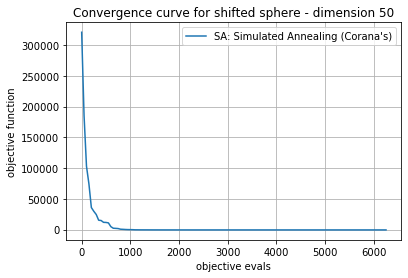

In [17]:
%%time
best = []
fevals = 0
for i in range(25):
    sol = sa(shifted_sphere(50), Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=5, start_range=1, pop_size=1)
    if best == [] or sol['champion solution'] < best['champion solution']:
        best = sol    
    fevals += sol['log'][-1][0]

report_convergence(best, fevals)

<hr>

## II.2 Dimension = 500

As the function sphere is relatively simple let's explore the convergence of some algorithms, considering the parameters necessary to error less than .1%

c:\users\fonse\pythonenvs\venv_lab\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


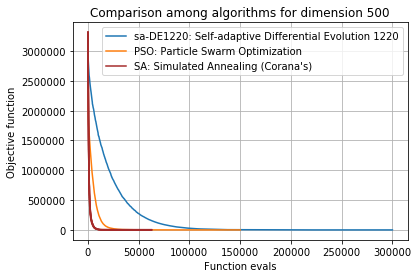

In [28]:
prob = pg.problem(shifted_sphere(500))
stats = []

pop_size = [150, 50]

udas = [pg.de1220(gen=2000, allowed_variants=[7], variant_adptv=1, ftol=1e-09, xtol=1e-09), 
        pg.pso(gen=3000, omega= .7, eta1=0.5, eta2=4, max_vel = .05, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False)]
for uda, p in zip(udas, pop_size): 
    logs = []
    best = []
    evals = []
    start_time = time.time()
    for i in range(25):
        algo = pg.algorithm(uda)
        algo.set_verbosity(1) # regulates both screen and log verbosity
        pop = pg.population(prob, p)
        sol = algo.evolve(pop)
        logs.append(algo.extract(type(uda)).get_log())
        best.append(sol.champion_f)
        evals.append(sol.problem.get_fevals())
    
    end_time = time.time()
    logs = np.array(logs)
    stats.append([algo.get_name(), (end_time-start_time)/25, np.mean(np.array(evals)), np.max(np.array(best)), 
                    np.min(np.array(best)), np.mean(np.array(best)), np.median(np.array(best))])
    avg_log = np.average(logs,0)
    plt.plot(avg_log[:,1],avg_log[:,2] , label=algo.get_name())
    
# Simulated annealing
logs = []
best = []
evals = []
algo = pg.algorithm(pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=5, start_range=1))
algo.set_verbosity(1)
pop = pg.population(prob, 1)
start_time = time.time()                    
for i in range(5): 
    sol = algo.evolve(pop)
    logs.append(algo.extract(pg.simulated_annealing).get_log())
    best.append(sol.champion_f)
    evals.append(sol.problem.get_fevals())
end_time = time.time()

for i in range(5): 
     plt.plot([l[0] for l in logs[i]],[l[1] for l in logs[i]],"brown")
plt.plot([0,0],[1,1],"brown", label=algo.get_name()) 

logs = np.array(logs)
stats.append([algo.get_name(), (end_time-start_time)/25, np.mean(np.array(evals)), np.max(np.array(best)), 
                    np.min(np.array(best)), np.mean(np.array(best)), np.median(np.array(best))])

plt.title('Comparison among algorithms for dimension ' + str(prob.get_nx()))
plt.xlabel('Function evals')
plt.ylabel('Objective function')
plt.legend() 
plt.grid() 

In [29]:
df_stats = pd.DataFrame(stats, columns=['algorithm', 'avg computational time (sec)', 'avg function evals' , 
                                        'max', 'min', 'avg', 'median'])
df_stats

,algorithm,avg computational time (sec),avg function evals,max,min,avg,median
0,sa-DE1220: Self-adaptive Differential Evolution 1220,17.349531,300150.0,86.081827,-449.207267,-418.523073,-443.369483
1,PSO: Particle Swarm Optimization,15.043017,150050.0,-446.632522,-449.718323,-449.262343,-449.531225
2,SA: Simulated Annealing (Corana's),0.792857,62501.0,4258.287350,-450.000000,491.657470,-450.000000


### Parameters selection

As we did with dimension 50 we are going to test different values for temperature, range and mutations parameters  for in order to choose the one that give us th best result.

In [31]:
udas = [pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=10, n_range_adj=5, bin_size=5, start_range=1), 
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=5, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=4, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=4, bin_size=5, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=3, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=3, n_range_adj=3, bin_size=3, start_range=1)]

df = statistics(shifted_sphere(500), udas, epochs = 1)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 10, Number of range adjustments: 5, Bin size: 5, Starting range: 1, Seed: 3566585964, Verbosity: 1]",0.241026,125001,-450.000000,-450.000000,-450.000000,-450.000000
1,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 5, Number of range adjustments: 5, Bin size: 5, Starting range: 1, Seed: 1685652084, Verbosity: 1]",0.120411,62501,-449.999998,-449.999998,-449.999998,-449.999998
2,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 5, Number of range adjustments: 5, Bin size: 4, Starting range: 1, Seed: 1582586983, Verbosity: 1]",0.095834,50001,-449.999986,-449.999986,-449.999986,-449.999986
3,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 5, Number of range adjustments: 4, Bin size: 5, Starting range: 1, Seed: 2671318705, Verbosity: 1]",0.095629,50001,-449.999896,-449.999896,-449.999896,-449.999896
4,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 5, Number of range adjustments: 5, Bin size: 3, Starting range: 1, Seed: 3725933879, Verbosity: 1]",0.070940,37501,-144.873216,-144.873216,-144.873216,-144.873216
5,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 3, Number of range adjustments: 3, Bin size: 3, Starting range: 1, Seed: 4033171549, Verbosity: 1]",0.026595,13501,276.048207,276.048207,276.048207,276.048207


After analyzing the statistics of the different parameters we decide for the following configuration:

- Ts = 1
- Tf = 1e-12
- n_T_adj = 10
- n_range_adj = 5
- bin_size = 5
- start_range = 1

Number of function evaluations:  3125000.0
Final solution vector:  [ 9.72499337e+01  7.70609851e+01 -1.90311461e+01  2.54287003e+01
 -2.29088020e+01  6.95721720e+01  5.36971401e+00  6.14807302e+01
 -2.13006982e+01  9.23468174e+01 -9.39758825e+01  9.07459881e+01
  4.28769755e+01  2.93096439e+01 -1.06695486e+01 -6.50746236e+01
  6.70494196e+01  9.40187671e+01 -7.30050249e+01 -4.98021999e+01
  8.20014270e+01  3.52931852e+01  2.46321490e+01  2.44313881e+00
 -9.93034460e+01 -5.46223411e+01  9.56914594e+01  7.22504812e+01
 -9.71229575e+01 -2.84462417e+00 -1.67194077e+01  5.45804810e+01
 -2.37049839e+00  4.51291179e+00  5.64098819e+01  1.82458696e+01
 -7.47214437e+01 -7.80561469e+01  3.25810786e+01  9.94186266e+01
 -3.07638201e+01 -6.47890979e+01 -8.64222096e+01 -3.81208244e+01
 -3.30480346e+01 -2.47664910e+01  9.04413665e+01  4.38641018e+01
  5.58684870e+01  2.35317307e+01  2.98476625e+01  5.12566582e+01
 -7.04331642e+01  1.98907315e+01  7.97217355e+01 -6.56134313e+01
  6.37856194e+01 -8.614

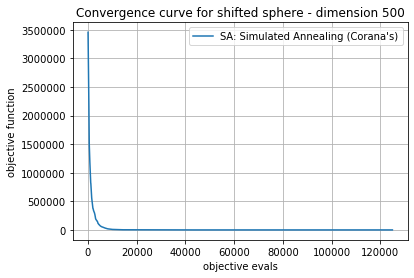

In [33]:
%%time
best = []
fevals = 0
for i in range(25):
    sol = sa(shifted_sphere(500), Ts=1, Tf=1e-12, n_T_adj=10, n_range_adj=5, bin_size=5, start_range=1, pop_size=1)
    if best == [] or sol['champion solution'] < best['champion solution']:
        best = sol    
    fevals += sol['log'][-1][0]

report_convergence(best, fevals)